In [1]:
!pip install -U portalocker>=2.0.0

In [2]:
!pip install -Uqq ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.8 MB/s eta 0:00:00


In [3]:
import ipdb
%pdb off
from torch import nn

Automatic pdb calling has been turned OFF


#Задание 1: Классификация текстовых данных


В этой домашней работе вам нужно реализовать классификатор новостей по содержанию новости. Для этого мы будем использовать утилиты из библиотеки `torchtext`.

## Датасет
AG News (новостной корпус AG) является поднабором корпуса новостных статей AG, созданным путем сбора заголовков и описаний статей из 4 крупнейших классов корпуса AG («Мир», «Спорт», «Бизнес», «Наука/Техника»). AG News содержит 30 000 обучающих и 1 900 тестовых образцов на каждый класс.

Набор данных `AG_NEWS` имеет четыре метки:
``` {.sourceCode .sh}
1 : World
2 : Sports
3 : Business
4 : Sci/Tec
```

Загрузим датасет и посмотрим на него:

In [4]:
import torch
from torchtext.datasets import AG_NEWS

train_iter = iter(AG_NEWS(split="train"))

In [5]:
print(next(train_iter))
print(next(train_iter))

(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")
(3, 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.')


По аналогии с тем, как мы сопоставляли номера буквам, здесь мы будем сопоставлять номера словам. Для этого мы используем простейший встроенный токенайзер `basic_english`.

In [6]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")
train_iter = AG_NEWS(split="train")


def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [7]:
vocab(tokenizer("here is an example"))

[475, 21, 30, 5297]

In [8]:
vocab(["news"])

[136]

In [9]:
vocab(['here', 'is', 'an', 'example'])

[475, 21, 30, 5297]

In [10]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [11]:
text_pipeline('here is the an example string')

[475, 21, 2, 30, 5297, 3578]

Эта функция `collate_batch` предназначена для подготовки батча данных перед его передачей в модель при обучении или тестировании в PyTorch. Она принимает список кортежей, где каждый кортеж содержит метку и текст, и выполняет несколько шагов: преобразует метки и тексты в тензоры PyTorch, генерирует список offset-ов для указания начала каждого текста в объединенном тензоре текстов (что важно для эффективной обработки переменных длин текстов в батче), и в конце собирает все эти данные в единые тензоры, готовые к использованию моделью. Функция упрощает подготовку данных, обеспечивая необходимую предобработку и упаковку данных в формат, подходящий для обработки нейронной сетью.








In [15]:
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)


train_iter = AG_NEWS(split="train")
dataloader = DataLoader(
    train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch
)

## Модель

Реализуйте модель, которая состоит из слоя [nn.EmbeddingBag](https://pytorch.org/docs/stable/generated/torch.nn.EmbeddingBag.html#torch.nn.EmbeddingBag) плюс линейный слой для целей классификации. nn.EmbeddingBag с режимом по умолчанию "mean" вычисляет среднее значение "мешка" эмбеддингов. Хотя текстовые записи здесь имеют разную длину, модуль nn.EmbeddingBag не требует здесь дополнения, поскольку длины текстов сохраняются в смещениях.

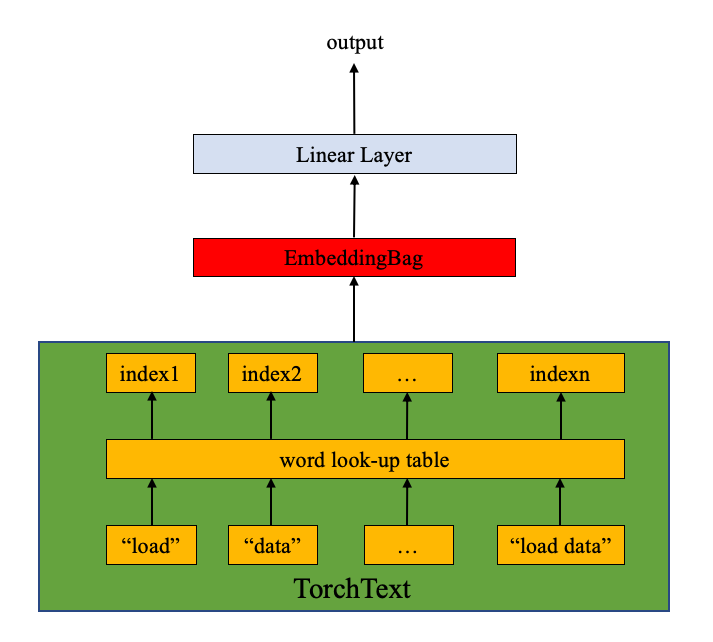

In [16]:
class textclassificationmodel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()

        self.embbag = nn.EmbeddingBag(vocab_size, embed_dim)
        self.out = nn.Linear(in_features=embed_dim, out_features=num_class)
        self.init_weights()


    def init_weights(self):
        initrange = 0.5
        for module in self.children():
            if isinstance(module, nn.Linear):
                torch.nn.init.zeros_(
                    tensor = module.bias
                )

            torch.nn.init.uniform_(
                tensor = module.weight,
                a = -initrange,
                b = initrange
            )


    def forward(self, text, offsets):

        layer_1 = self.embbag(text, offsets)
        out = self.out(layer_1)

        return out

In [17]:
class TextClassificationModelWithBasicEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModelWithBasicEmbedding, self).__init__()

        self.emb = nn.Embedding(vocab_size, embed_dim)
        self.out = nn.Linear(in_features=embed_dim, out_features=num_class)
        self.init_weights()


    def init_weights(self):
        initrange = 0.5
        for module in self.children():
            if isinstance(module, nn.Linear):
                torch.nn.init.zeros_(
                    tensor = module.bias
                )

            torch.nn.init.uniform_(
                tensor = module.weight,
                a = -initrange,
                b = initrange
            )


    def forward(self, text, offsets):

        minibatch_ix = {}

        for ix, offset in enumerate(offsets):
            if ix == offsets.size(0) - 1:
                minibatch_ix[offset] = torch.tensor(text.size(0))
            else:
                minibatch_ix[offset] = offsets[ix + 1]

        out = []
        for b_begin, b_end in minibatch_ix.items():
            minibatch_begin_ix = b_begin.item()
            minibatch_end_ix = b_end.item()

            layer_1 = self.emb(
                text[minibatch_begin_ix:minibatch_end_ix]
            )
            out.append(self.out(layer_1))

        for ix, minibatch_res in enumerate(out):
            out[ix] = torch.mean(minibatch_res, dim=0)

        out = torch.stack(out).type(dtype=torch.float32)
        return out

In [18]:
class RNNBasedTextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class, hidden_layer_size = 128, layers_num= 10):
        super(RNNBasedTextClassificationModel, self).__init__()

        self.hd_s = hidden_layer_size
        self.layers_num = layers_num

        self.embbag = nn.EmbeddingBag(vocab_size, embed_dim)

        self.rnn = nn.RNN(
            input_size = embed_dim,
            hidden_size = self.hd_s,
            num_layers = self.layers_num,
            nonlinearity='relu'
        )

        self.out = nn.Linear(in_features=self.hd_s, out_features = num_class)
        self.init_weights()


    def init_weights(self):
        initrange = 0.5
        for module in self.children():
            if isinstance(module, nn.Linear):
                torch.nn.init.zeros_(
                    tensor = module.bias
                )


            if not isinstance(module, nn.RNN):
                torch.nn.init.uniform_(
                tensor = module.weight,
                a = -initrange,
                b = initrange
            )
            else:
                for sub in module.children():
                    torch.nn.init.uniform_(
                        tensor = module.weight,
                        a = -initrange,
                        b = initrange
            )



    def forward(self, text, offsets):
        emb = self.embbag(text, offsets)
        rnn_layer_out, hn = self.rnn(emb)
        out = self.out(rnn_layer_out)
        return out


In [19]:
class GRUBasedTextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class, hidden_layer_size = 128, layers_num= 10):
        super(GRUBasedTextClassificationModel, self).__init__()

        self.hd_s = hidden_layer_size
        self.layers_num = layers_num

        self.embbag = nn.EmbeddingBag(vocab_size, embed_dim)

        self.gru = nn.GRU(
            input_size = embed_dim,
            hidden_size = self.hd_s,
            num_layers = self.layers_num,
        )

        self.out = nn.Linear(in_features=self.hd_s, out_features = num_class)
        self.init_weights()


    def init_weights(self):
        initrange = 0.5
        for module in self.children():
            if isinstance(module, nn.Linear):
                torch.nn.init.zeros_(
                    tensor = module.bias
                )


            if not isinstance(module, nn.GRU):
                torch.nn.init.uniform_(
                tensor = module.weight,
                a = -initrange,
                b = initrange
            )
            else:
                for sub in module.children():
                    torch.nn.init.uniform_(
                        tensor = module.weight,
                        a = -initrange,
                        b = initrange
            )



    def forward(self, text, offsets):
        emb = self.embbag(text, offsets)
        gru_layer_out, hn = self.gru(emb)
        out = self.out(gru_layer_out)
        return out

In [20]:
class RNNBasedTextClassificationModelWithBasicEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class, hidden_layer_size = 128, layers_num= 10):
        super(RNNBasedTextClassificationModelWithBasicEmbedding, self).__init__()

        self.hd_s = hidden_layer_size
        self.layers_num = layers_num

        self.emb = nn.Embedding(vocab_size, embed_dim)

        self.rnn = nn.RNN(
            input_size = embed_dim,
            hidden_size = self.hd_s,
            num_layers = self.layers_num,
            nonlinearity='relu'
        )

        self.out = nn.Linear(in_features=self.hd_s, out_features = num_class)
        self.init_weights()


    def init_weights(self):
        initrange = 0.5
        for module in self.children():
            if isinstance(module, nn.Linear):
                torch.nn.init.zeros_(
                    tensor = module.bias
                )


            if not isinstance(module, nn.RNN):
                torch.nn.init.uniform_(
                tensor = module.weight,
                a = -initrange,
                b = initrange
            )
            else:
                for sub in module.children():
                    torch.nn.init.uniform_(
                        tensor = module.weight,
                        a = -initrange,
                        b = initrange
            )



    def forward(self, text, offsets):
        minibatch_ix = {}

        for ix, offset in enumerate(offsets):
            if ix == offsets.size(0) - 1:
                minibatch_ix[offset] = torch.tensor(text.size(0))
            else:
                minibatch_ix[offset] = offsets[ix + 1]

        out = []
        for b_begin, b_end in minibatch_ix.items():
            minibatch_begin_ix = b_begin.item()
            minibatch_end_ix = b_end.item()

            layer_1 = self.emb(
                text[minibatch_begin_ix:minibatch_end_ix]
            )
            rnn_layer_out, hn = self.rnn(layer_1)
            out.append(self.out(rnn_layer_out))

        for ix, minibatch_res in enumerate(out):
            out[ix] = torch.mean(minibatch_res, dim=0)

        out = torch.stack(out).type(dtype=torch.float32)
        return out

In [21]:
class FlattenConsecutive():
    def __init__(self, n):
        self.n = n

    def __call__(self, X:torch.Tensor):
        X = X[None, ...] if len(X.shape) == 2 else X
        X = X if X.shape[1] % 2 == 0 else torch.cat( (X[:,0].view(-1, *X[:,0].shape), X), 1)
        """
        это вот то место из ответов внизу, где я говорю про дублирование
        для нечетного количества токенов, чтобы избегать коллизий при из-
        менении размерностей
        """
        B,T,C = X.shape
        X = X.view(B, T//self.n, C*self.n)
        self.out = X
        return self.out

class WaveNet(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(WaveNet, self).__init__()

        self.nhidden = 128
        self.emb = nn.Embedding(vocab_size, embed_dim)
        self.cons_flatten = FlattenConsecutive(2)
        self.tanh = nn.Tanh()
        self.lin_1 = nn.Linear(in_features= embed_dim*2, out_features=self.nhidden)
        self.lin_2 = nn.Linear(in_features= self.nhidden*2, out_features=self.nhidden*2)
        self.lin_3 = nn.Linear(in_features= self.nhidden*4, out_features=self.nhidden*4)

        self.out = nn.Linear(in_features=self.nhidden*8, out_features=num_class)
        '''
        связку cons_flatten + linear можно повторять необходимое кол-во,
        главное не забывать обновлять размерность линейного слоя,
        которая увеличиваеся на каждой итерации в 2 два раза.
        в оригинальной работе 4 слоя, три скрытых и один на выход.
        вернее я так думал, пока не понял наконец, что для задания
        количества уровней необходимо будет фиксировать количество слов в новости.
        пришлось колхозить.
        '''

        self.init_weights()


    def init_weights(self):
        initrange = 0.5
        for module in self.children():
            if isinstance(module, FlattenConsecutive) or isinstance(module, nn.Tanh):
                continue

            if isinstance(module, nn.Linear):
                torch.nn.init.zeros_(
                    tensor = module.bias
                )

            torch.nn.init.uniform_(
                tensor = module.weight,
                a = -initrange,
                b = initrange
            )


    def forward(self, text, offsets):

        minibatch_ix = {}

        for ix, offset in enumerate(offsets):
            if ix == offsets.size(0) - 1:
                minibatch_ix[offset] = torch.tensor(text.size(0))
            else:
                minibatch_ix[offset] = offsets[ix + 1]

        out = []
        for b_begin, b_end in minibatch_ix.items():
            minibatch_begin_ix = b_begin.item()
            minibatch_end_ix = b_end.item()

            minibatch = text[minibatch_begin_ix:minibatch_end_ix]

            embedded = self.emb(minibatch)

            fl_1 = self.cons_flatten(embedded)
            lin1 = self.lin_1(fl_1)
            t_1 = self.tanh(lin1)

            fl_2 = self.cons_flatten(t_1)
            lin2 = self.lin_2(fl_2)
            t_2 = self.tanh(lin2)

            fl_3 = self.cons_flatten(t_2)
            lin3 = self.lin_3(fl_3)
            t_3 = self.tanh(lin3)

            fl_out = self.cons_flatten(t_3)
            out3 = self.out(fl_out)
            t_out = self.tanh(out3)

            fixed_out = torch.mean(t_out, dim=1)

            out.append(fixed_out.squeeze_(0))

        out = torch.stack(out).type(dtype=torch.float32)
        return out

Automatic pdb calling has been turned ON


KeyboardInterrupt: 

> /usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py(266)backward()
    264     # some Python versions print out the first line of a multi-line function
    265     # calls in the traceback and some print out the last line
--> 266     Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    267         tensors,
    268         grad_tensors_,




PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 361, in set_quit
    sys.settrace(None)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/debugger.py", line 1075, in cmdloop
    sys.settrace(None)



--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
ipdb> 


## Обучение

Восполните строчки для обучения модели.

Получите точность на валидации выше 90%.

Ответ:
Получена на TextClassificationModel на 100 эпохах.

In [ ]:
train_iter = AG_NEWS(split="train")
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64

torch.manual_seed(42) # for the favor of consistency in a models comparision process

# model = TextClassificationModel(vocab_size, emsize, num_class).to(device)
# model = TextClassificationModelWithBasicEmbedding(vocab_size, emsize, num_class).to(device)
# model = RNNBasedTextClassificationModel(vocab_size, emsize, num_class,layers_num=num_class).to(device)
# model = RNNBasedTextClassificationModelWithBasicEmbedding(vocab_size, emsize, num_class, layers_num=num_class).to(device)
# model = GRUBasedTextClassificationModel(vocab_size, emsize, num_class,layers_num=num_class).to(device)
model = WaveNet(vocab_size, emsize, num_class).to(device)

import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()

        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()


def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

# Hyperparameters

EPOCHS = 100 # epoch
LR = 1e-5
BATCH_SIZE = 64  # batch size for training

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.1)
total_accu = None
train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = random_split(
    train_dataset, [num_train, len(train_dataset) - num_train]
)

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print("-" * 59)
    print(
        "| end of epoch {:3d} | time: {:5.2f}s | "
        "valid accuracy {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, accu_val
        )
    )
    print("-" * 59)

Проверяем результат на тестовой выборке:

In [ ]:
print("Checking the results of test dataset.")
accu_test = evaluate(test_dataloader)
print("test accuracy {:8.3f}".format(accu_test))

Протестируем модель на новости про гольф:

In [ ]:
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}


def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1


ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

model = model.to("cpu")

print("This is a %s news" % ag_news_label[predict(ex_text_str, text_pipeline)])

# Задание 2

1. В чем разница между`EmbeddingBag` и `Embedding`?
 Реализуйте модель на основе `Embedding` и сравните качество и скорость выполнения.

    1.1
    Разница в том, как формируется эмбеддинг, а точнее, на основе чего. В случае с nn.Embedding, это преобразование каждого токена, в нашем случае слова, в эмбеддинг нужной размерности. Для примера, пусть в нашем словаре 10 слов, а размер эмбеддинга составляет 4. Рассмотрим предложение, в котором 5 слов, т.е. 5 кандидатов на преобазование в эмбеддинг. Значит, после отображение, мы получим 5 векторов длины 4 и будем рады. В случае с nn.EmbeddingBag мы получим в той же ситуации один вектор длиной 4. Произойдет это потому, что в данном случае nn.EmbeddingBag предполагает агрегацию токенов, точнее их представлений в виде эмбеддингов (через среднее, сумму или максимум). В данном примере я молча предположил, что такая агрегация происходит на базе предложения, что на самом деле не верно в общем случае, ведь в наших моделях выше агрегация происходит на базе целой новости, которая может включать не одно предложение. Понятно, что это nn.EmbeddingBag можно заменить с использованием базовых агрегационных функций и простого nn.Embedding, но такой вариант будет работать дольше, так как будут отсутствовать оптимизации низкого уровня, что и можно увидеть исходя из скорости работы моделей. А вот точность в итоге близка, так как идейно разницы для модели нет, как происходила агрегация.
2. Реализуйте `TextClassificationModel` на основе RNN или GRU/LSTM. Добейтесь существенного улучшения точности модели.
    2.1
    Существенного улучшения в работе нет с испольованием RNN, что не так чтобы сильно странно, ведь RNN должна дать прирост, если кормить её словами, чтобы она видела последовательность. А если агрегировать, то тут особо она не будет выделяться в сравнении.
3. Реализуйте `TextClassificationModel` на основе WaveNet (как на лекции). Сравните с реккурентной моделью.
    3.1
    Надеюсь, что я правильно понял, как Causal Convolution должна быть реализована. По сути, всё это очень близко к использованию сверточного слоя. Просто в результате работы сверки мы размерность нового пространства выбираем из расположения лун, а в Causal мы хотим пролучать +- тоже, но размерности в данном случае выходного случая определены заранее, так как мы производим преобразование в лоб, вмешивая напрямую параметры соседних токенов. Если я прав, то продолжая говорить о примере выше, наши токены будут попарно сконкатенированы*, и на выходе мы получим из 5 токенов 3 вектора длиной длиной 4. А потом будем повторять эту процедуру, пока не получим единсвенный вектор длиной 4. Т.е. отсылаясь к лекции, растянем нагруженный слой, давая модели больше пространства для выделение характеристик текста.
    
    *(непарный токен (наивно) сконкатенировать с самим собой, ведь по идее, данный приём с опциональной сверткой нам нужен для сообщения модели информации о сущесвовании порядка в данных (близости по распределению у соседних токенов, что тоже самое, что и их близость в контексте информационной нагрузки (близость смысловой связи, во времени и прочее)), а данный порядок для первого токена не имеет смысла, так как первое слово не имеет перед собой смысловых элементов по определению.)

    upd

    я так в итоге по человечески и не понял, как бороться с тем что в случае новостей длина предложений разная, а значит мы по хорошему точно сказать не можем (только оценить, но это опять же плохо идейно, ведь новость не обязана укладываться в рамки), а какая нам нужна глубина для честного спуска с шагом в 2. Варианта два. Можно агрегировать в конце, сворачивая на последнем этапе результат искусственно, что я и буду делать, либо оценить и написать n слоёв в предположении, что новости будут иметь некую длину.

    upd 2

    учится... долго. но учится, возможно там и будет результат.
    31 эпоха и всё шло нормально, но гпу не бесплатное...
    последний рузультат на валидации: 0.754

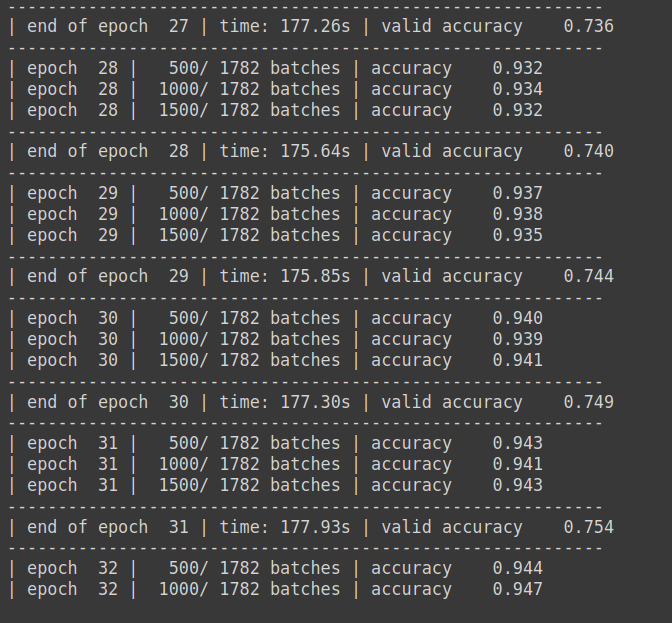